In [1]:
import sys, os
sys.path.append(os.path.join(os.path.pardir, 'python'))

In [2]:
import geometry as geo

In [3]:
minres = 10.0

In [4]:
geo.SlabSpline?

Init signature: geo.SlabSpline(xs, ys, res=None, name=None, sid=None, bctype='natural')
Docstring:      <no docstring>
File:           ~/repos/github/cianwilson/fenicsx_subduction/python/geometry.py
Type:           type
Subclasses:     


In [5]:
slab = geo.SlabSpline([0.0, 140.0, 240.0, 400.0], [0.0, -70.0, -120.0, -200.0], 
                       res=[2*minres, 1*minres, 1*minres, 6*minres], sid=1, name="Slab")
print(len(slab.points))

4


/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [6]:
# add partial coupling depths
slab.addpoint(80, "Slab::PartialCouplingDepth", res=1*minres)
slab.addpoint(82.5, "Slab::FullCouplingDepth", res=1*minres)
print(len(slab.points))

6


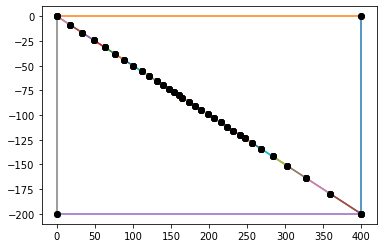

In [7]:
geom = geo.SubductionGeometry(slab, slab_rid=1, wedge_rid=2, 
                                    slab_side_sid=2, wedge_side_sid=3, slab_base_sid=7, top_sid=10,
                                    wedge_top_res=4*minres, slab_base_res=6*minres)
geom.plot()

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


['WedgeSide', 'LowerCrust']
7


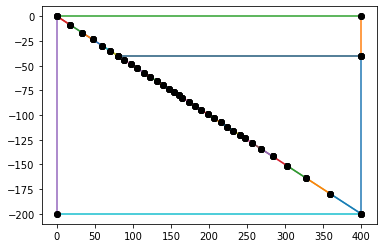

In [8]:
geom.addcrustlayer(40, "LowerCrust", sid=8, rid=3, slab_res=1*minres, side_res=4*minres, side_sid=5)
print([geom.wedge_side_lines[i].name for i in range(len(geom.wedge_side_lines))])
print(len(slab.points))
geom.plot()

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


['WedgeSide', 'LowerCrust', 'UpperCrust']


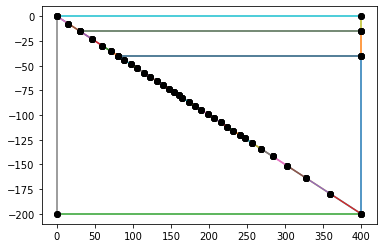

In [9]:
geom.addcrustlayer(15,"UpperCrust", sid=9, rid=4, slab_res= 2*minres, side_res=4*minres, side_sid=6)
print([geom.wedge_side_lines[i].name for i in range(len(geom.wedge_side_lines))])
geom.plot()

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


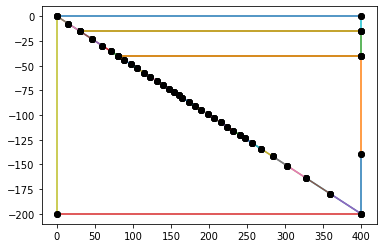

In [10]:
geom.addwedgesidepoint(139, "WedgeSide::InOut", line_name="UpperWedgeSide", res=4*minres, sid=4)
geom.plot()

/usr/lib/python3/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


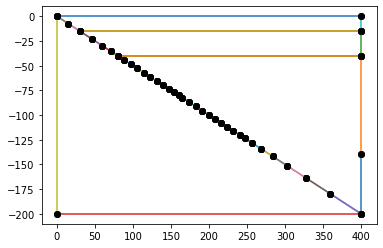

In [11]:
geom.addslabpoint(100, "Slab::DetectorPoint", res=1*minres, sid=1)
geom.plot()

In [12]:
geom.writegeofile("test.geo_unrolled")

In [13]:
geom.slab_spline.pids

[1, 1, 1, 1, 1, 1, 1, 1, 1]

In [14]:
geom.slab_spline.y

array([   0. ,  -15. ,  -40. ,  -70. ,  -80. ,  -82.5, -100. , -120. ,
       -200. ])

In [15]:
gmshmesh = geom.generategmshmesh()

In [16]:
gmshmesh?

Init signature: gmshmesh()
Docstring:      Model functions
File:           ~/.local/lib/python3.8/site-packages/gmsh-4.8.4-Linux64-sdk/lib/gmsh.py
Type:           type
Subclasses:     


gmsh.model.mesh